In [1]:
#jornada SPEI

In [1]:
library('tidyverse')
# Get spei tools, if not already installed use:
#devtools::install_github("gremau/rclimtools")
# Then load
library('rclimtools')

# Get the dataset
fname <- '../data/Jornada_USHCN_monthlyclimate.csv'
raw <- read_csv(fname, na=c('', 'NaN', 'NA'))

head(raw)

── Attaching packages ──────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 3108 Columns: 9
── Column specification ─────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): stationid, month, variable, station_name
dbl  (4): year, day, value, latitude
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


stationid,date,year,month,day,variable,value,station_name,latitude
<chr>,<date>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
USH00294426,1893-01-31,1893,jan,31,tavg,4.66,JORNADA EXP RANGE,32.6169
USH00294426,1893-02-28,1893,feb,28,tavg,6.34,JORNADA EXP RANGE,32.6169
USH00294426,1893-03-31,1893,mar,31,tavg,8.64,JORNADA EXP RANGE,32.6169
USH00294426,1893-04-30,1893,apr,30,tavg,14.02,JORNADA EXP RANGE,32.6169
USH00294426,1893-05-31,1893,may,31,tavg,17.07,JORNADA EXP RANGE,32.6169
USH00294426,1893-06-30,1893,jun,30,tavg,23.89,JORNADA EXP RANGE,32.6169


In [2]:
stn <- unique(raw$stationid)
stn

[1] "USH00294426"

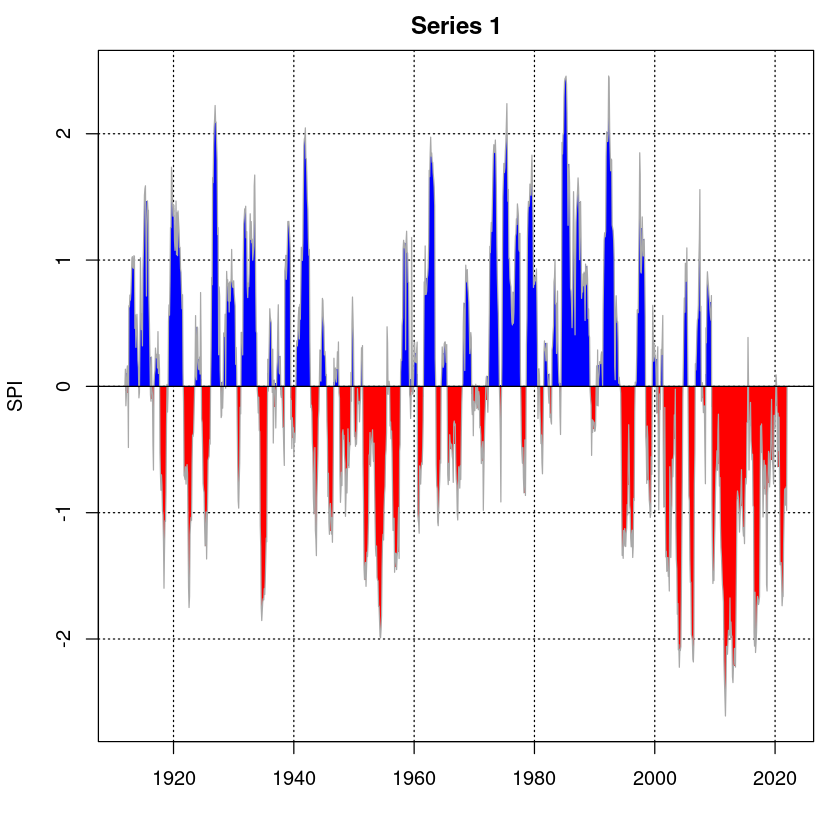

In [7]:
for (i in 1:length(stn)) {
    # Subset the main dataset and calculate PET
    stndf <- subset(raw, stationid==stn[i] & date > '1910-12-31') # For cross-site, limit to 1999 forward
    tavg <- subset(stndf, variable=='tavg')
    prcp <- subset(stndf, variable=='prcp')
    pet <- SPEI::thornthwaite(tavg$value, unique(tavg$latitude))
    # Prepare datetime index
    tavg$month <- lubridate::month(tavg$date)
    dateidx <- zoo::as.yearmon(paste(tavg$month, '/', tavg$year, sep=''), "%m/%Y")
    # Precip and PET timeseries
    prcp_xts <- xts::xts(prcp$value, order.by=dateidx)
    pet_xts <- xts::xts(as.numeric(pet), order.by=dateidx)
    # Climatic water differential
    cwdiff <- get_cwdiff(prcp_xts, pet_xts)
    
    # Now get 1year SPEI and extract values
    spei_12mo <- get_spei(cwdiff, int_per=12)  
    spei_xts <- xts::xts(as.vector(spei_12mo$fitted),  order.by=zoo::index(cwdiff))
    colnames(spei_xts) <- c('spei12mo')
    # Create a new dataframe (from tavg) and add SPEI values
    spei_site <- tavg
    spei_site$variable <- 'spei12mo'
    spei_site$value <- as.vector(spei_xts$spei12mo)
    spei_site['spei_date'] <- zoo::index(spei_xts)
    # Concatenate spei_site dataframes into 1
    if (i==1) {
        spei_out <- spei_site
    } else {
        spei_out <- rbind(spei_out, spei_site)
    }
}

In [8]:
write_csv(spei_out, '../data/Jornada_USHCN_12moSPEI_1911-present.csv')
head(spei_out)

stationid,date,year,month,day,variable,value,station_name,latitude,spei_date
<chr>,<date>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<yearmon>
USH00294426,1911-01-31,1911,1,31,spei12mo,NA,JORNADA EXP RANGE,32.6169,Jan 1911
USH00294426,1911-02-28,1911,2,28,spei12mo,NA,JORNADA EXP RANGE,32.6169,Feb 1911
USH00294426,1911-03-31,1911,3,31,spei12mo,NA,JORNADA EXP RANGE,32.6169,Mar 1911
USH00294426,1911-04-30,1911,4,30,spei12mo,NA,JORNADA EXP RANGE,32.6169,Apr 1911
USH00294426,1911-05-31,1911,5,31,spei12mo,NA,JORNADA EXP RANGE,32.6169,May 1911
USH00294426,1911-06-30,1911,6,30,spei12mo,NA,JORNADA EXP RANGE,32.6169,Jun 1911
